## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

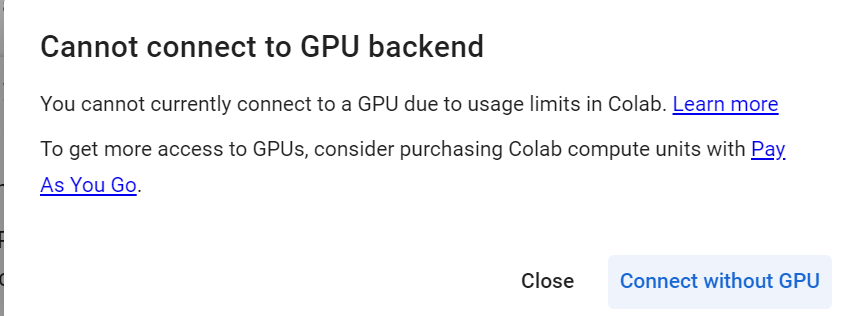

## **Installing and Importing Necessary Libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip3 install -U sentence-transformers gensim transformers tqdm -q

In [2]:
#!pip install numpy

In [3]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\amitesh.sinha\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# # uncomment and run the following code if Google Colab is being used and the dataset is in Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

## **Loading the dataset**

In [5]:
stock_news = pd.read_csv("stock_news.csv")

In [6]:
#Creating a copy of the dataset
data = stock_news.copy()

## **Data Overview**

In [7]:
# Read first 5 records of the dataset
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [8]:
# Read last 5 records of the dataset
data.tail()

,Date,News,Open,High,Low,Close,Volume,Label
344,2019-04-30,"Media mogul Oprah Winfrey, known for influenc...",50.764999,50.849998,49.7775,48.70879,186139600,-1
345,2019-04-30,"European shares fell on Tuesday, with banks u...",50.764999,50.849998,49.7775,48.70879,186139600,-1
346,2019-04-30,This article reports that the S&P 500 reached...,50.764999,50.849998,49.7775,48.70879,186139600,-1
347,2019-04-30,The Federal Reserve is anticipated to keep in...,50.764999,50.849998,49.7775,48.70879,186139600,-1
348,2019-04-30,"In the first quarter, South Korea's Samsung E...",50.764999,50.849998,49.7775,48.70879,186139600,0


In [9]:
# Read 5 random records
data.sample(5)

,Date,News,Open,High,Low,Close,Volume,Label
205,2019-02-20,Viaciom announced it will provide programming ...,42.797501,43.330002,42.747501,41.756977,104457600,0
256,2019-03-21,IOTA's partnership with payments and banking s...,47.505001,49.082500,47.452499,47.354347,204136800,-1
10,2019-01-02,The Australian dollar experienced significant...,41.740002,42.244999,41.482498,40.246914,130672400,0
286,2019-04-02,"Apple and other consumer brands, including LV...",41.852501,42.915001,41.820000,41.390125,125982000,0
109,2019-01-18,U.S. futures rose on Friday following reports...,39.375000,39.470001,38.994999,37.902481,135004000,1


In [10]:
# Get the number of Columns and rows in the dataset
data.shape
print("There are", data.shape[0], 'rows and', data.shape[1], "columns.")

There are 349 rows and 8 columns.


In [11]:
# find the null values and the totals
data.isnull().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

In [12]:
# To find the duplicated rows
data.duplicated().sum()

0

In [13]:
# To describe the object data type
data.describe(include=["object"]).T

,count,unique,top,freq
Date,349,71,2019-01-03,28
News,349,349,The tech sector experienced a significant dec...,1


In [14]:
# Print all the unique values of object type
for i in data.describe(include=["object"]).columns:
    print("Unique values in", i, "are :")
    print(data[i].value_counts())
    print("*" * 50)

Unique values in Date are :
Date
2019-01-03    28
2019-01-30    17
2019-01-02    14
2019-04-17    12
2019-03-25    11
              ..
2019-02-19     1
2019-04-25     1
2019-04-26     1
2019-02-07     1
2019-04-16     1
Name: count, Length: 71, dtype: int64
**************************************************
Unique values in News are :
News
The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.                                                           1
Boeing's NYSE BA stock experienced significant losses in premarket trade on Tuesday, as the company faced continued scrutiny following the second crash of a 737 Max 8 plane. The crashes resulted in groundings of the fleet in Singapore, Australia, China, and Indonesia, but n

In [15]:
# to find unique values of all the columns
data.nunique()

Date       71
News      349
Open       70
High       70
Low        71
Close      71
Volume     71
Label       3
dtype: int64

In [16]:
# Get the info of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [17]:
data['Date'] = pd.to_datetime(data['Date'])  # to convert the 'Date' column in the 'stock' DataFrame to datetime format.

In [18]:
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [19]:
# describe the dataset
data.describe()

,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

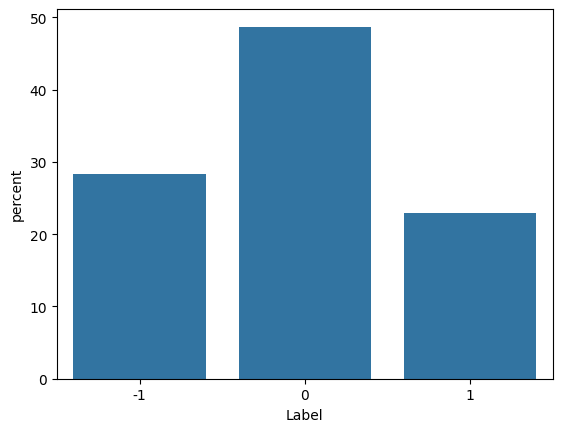

In [20]:
sns.countplot(data=data, x="Label", stat="percent");

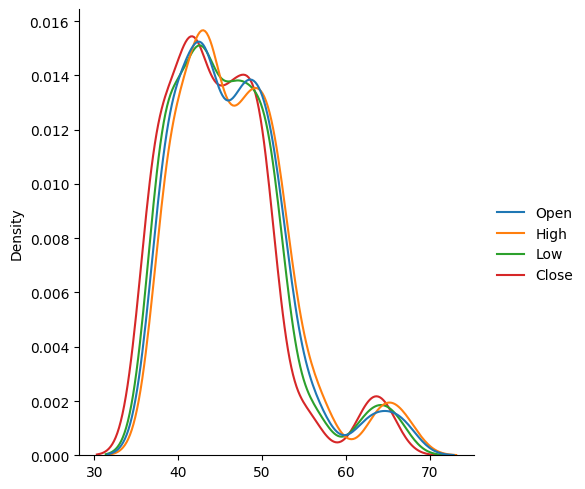

In [21]:
sns.displot(data=data[["Open", "High","Low","Close"]], kind="kde", palette="tab10"); # Complete the code to plot a density plot of ["Open","High","Low","Close"] all in a single plot

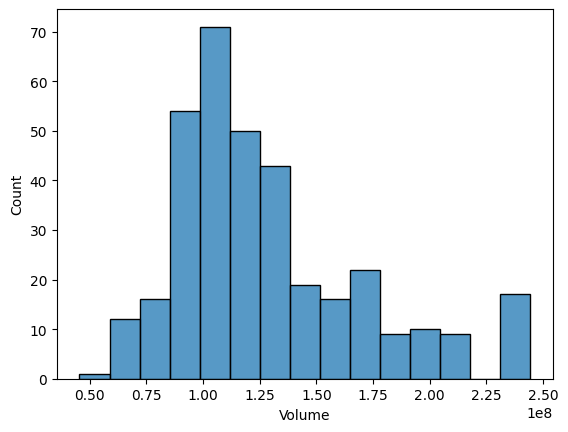

In [22]:
sns.histplot(data, x='Volume'); # Complete the code to plot a histogram of Volume

In [23]:
#Calculating the total number of words present in the news content.
data['news_len'] = data['News'].apply(lambda x: len(x.split(' ')))


data['news_len'].info    #Complete the code to print the statistical summary for the news content length

<bound method Series.info of 0      46
1      51
2      49
3      51
4      50
       ..
344    48
345    41
346    48
347    58
348    54
Name: news_len, Length: 349, dtype: int64>

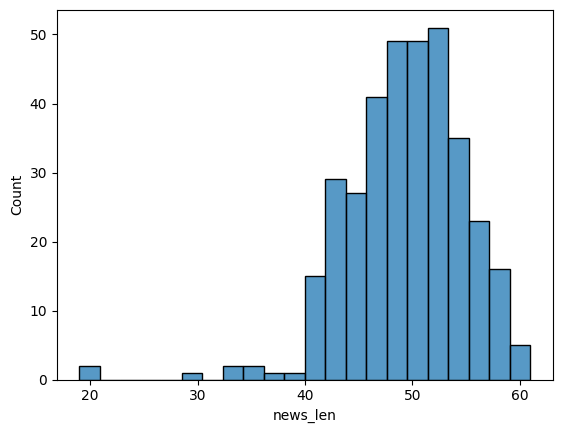

In [24]:
sns.histplot(data=data,x='news_len'); #Complete the code to plot a histogram of news_len column

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

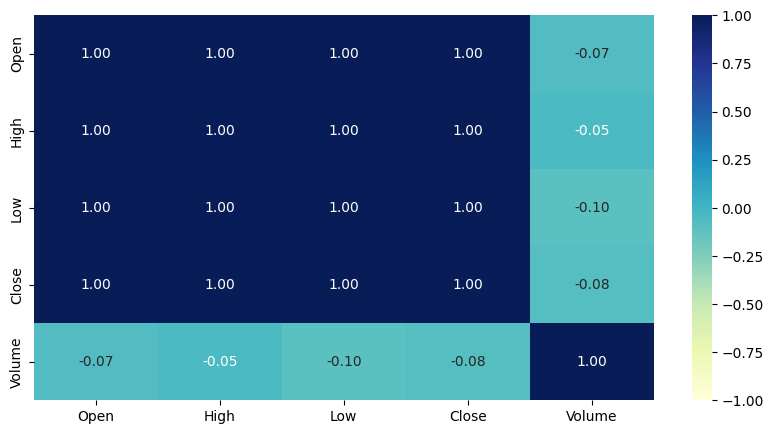

In [25]:
# Create the heatmap for numerical columns
cols = ["Open", "High","Low","Close","Volume"]
plt.figure(figsize=(10,5))
sns.heatmap(data[cols].corr(),annot=True,cmap='YlGnBu',vmin=-1,vmax=1,fmt=".2f")
plt.show()

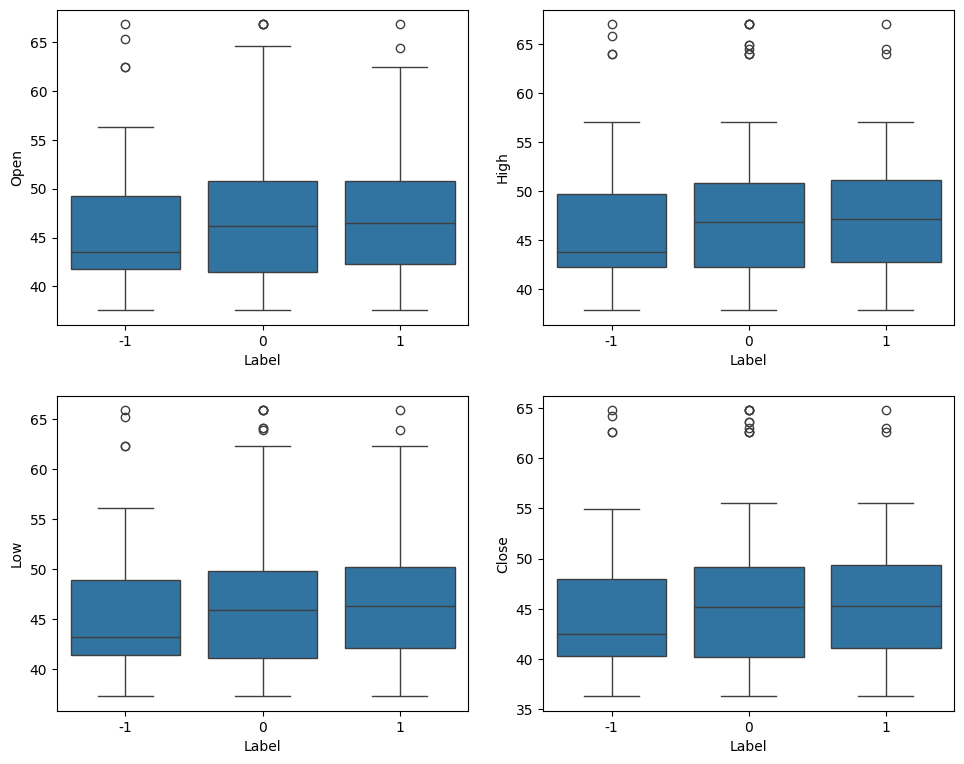

In [26]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=data, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

#### Label vs Volume

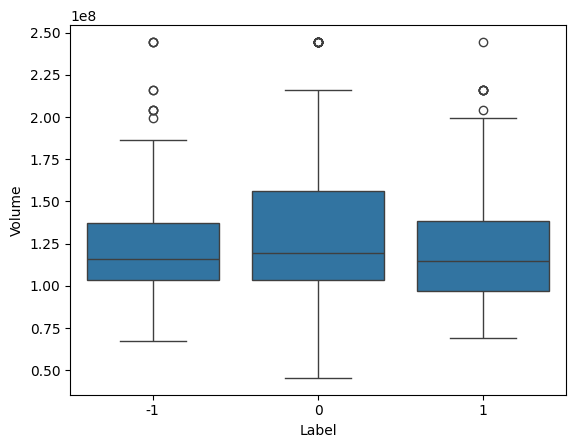

In [27]:
sns.boxplot(
    data=data, x="Label", y="Volume"  # Complete the code to plot a boxplot of Label vs Volume
);

#### Date vs Price (Open, High, Low, Close)

In [28]:
stock_daily =data.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


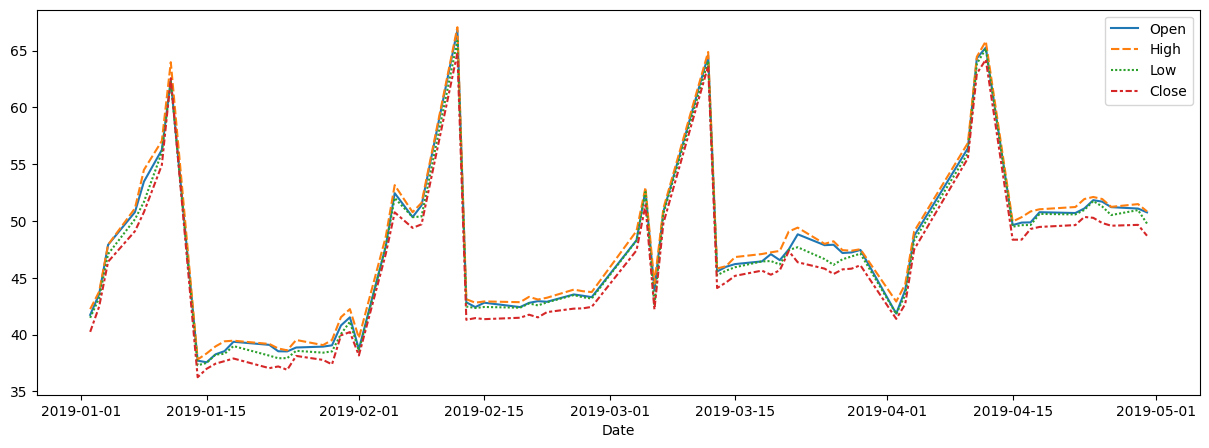

In [29]:
plt.figure(figsize=(15,5))
sns.lineplot(stock_daily.drop("Volume", axis=1)); #Complete the code to plot a lineplot of all the variables except Volume

#### Volume vs Close Price

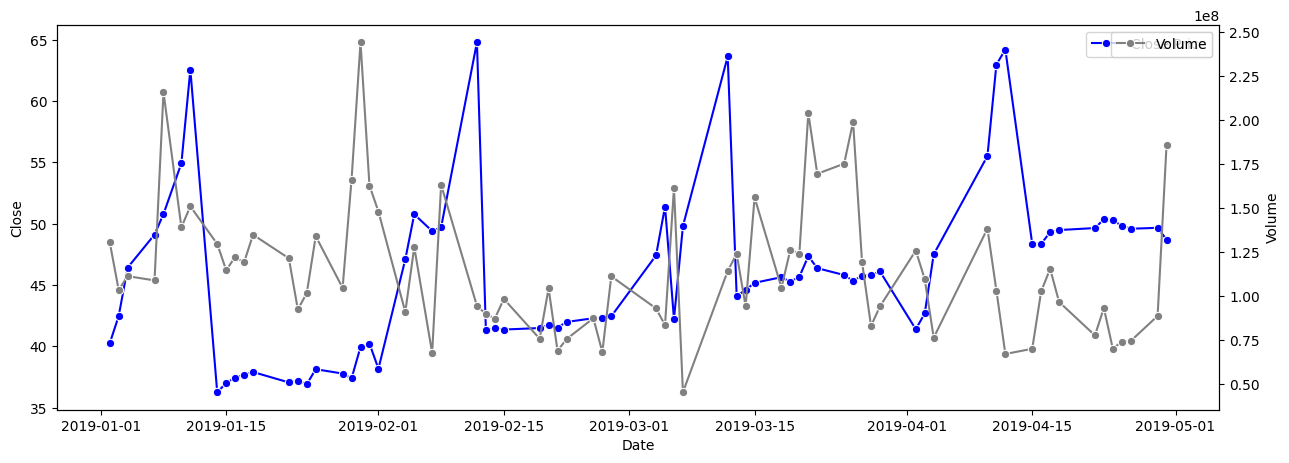

In [30]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

## **Data Preprocessing**

In [31]:
data["Date"].info #Complete the code to print the statistical summary of the 'Date' column

<bound method Series.info of 0     2019-01-02
1     2019-01-02
2     2019-01-02
3     2019-01-02
4     2019-01-02
         ...    
344   2019-04-30
345   2019-04-30
346   2019-04-30
347   2019-04-30
348   2019-04-30
Name: Date, Length: 349, dtype: datetime64[ns]>

#### Train-test-validation Split

In [32]:
X_train = data[(data['Date'] < '2019-04-01')].reset_index()    #Complete the code to select all rows where the 'Date' is before '2019-04-01'
X_val = data[(data['Date'] >= '2019-04-01') & (data['Date'] < '2019-04-16')].reset_index()    #Complete the code to select all rows where the 'Date' is from '2019-04-01 to '2019-04-16' (excluded)
X_test = data[data['Date'] >= '2019-04-16'].reset_index()    #Complete the code to select all rows where the 'Date' is from '2019-04-16' till the end.

In [33]:
# Complete the code to pick the 'Label' column as the target variable
y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()

In [34]:
#Complete the code to print the shape of X_train,X_val,X_test,y_train,y_val and y_test
print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 10)
Validation data shape (21, 10)
Test data shape  (42, 10)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


## **Word Embeddings**

#### Word2Vec

In [35]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in data['News'].values]

In [36]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [37]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


##### check out a few word embeddings obtained using the model.

In [38]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([ 2.31035682e-03,  4.53927629e-02,  3.52640636e-03,  2.42153574e-02,
       -1.80081266e-03, -5.10547906e-02,  3.42578441e-02,  8.41245502e-02,
        9.34075192e-03, -1.60684530e-02,  1.07888402e-02, -2.15512179e-02,
        2.44997488e-03,  1.18751144e-02, -3.00875735e-02, -2.56322157e-02,
        2.00015921e-02, -1.30317789e-02, -1.88524940e-03, -1.34740677e-02,
       -2.50767246e-02,  2.22367910e-03,  3.74867097e-02,  6.61785714e-03,
        1.43834511e-02,  5.77143533e-03, -4.26988341e-02,  6.47516269e-03,
       -1.87937133e-02, -3.52474488e-02,  1.30951554e-02, -2.09695380e-02,
        3.91435018e-03, -2.87549454e-03, -3.35835898e-03,  1.75789092e-02,
        1.66896116e-02, -3.83518711e-02,  2.06079567e-03, -9.92193539e-03,
       -1.59588140e-02, -2.05635489e-03, -9.52816918e-04, -2.69448254e-02,
        1.55129181e-02,  4.00980748e-02,  9.87775158e-04,  1.08753042e-02,
       -1.60628138e-03,  2.74559539e-02,  2.04274617e-02,  5.99671714e-03,
       -1.69798303e-02,  

In [39]:
# Checking the word embedding of a random word
word = "economy"
model_W2V.wv[word]

array([ 2.27740244e-03,  6.59704767e-03, -2.99708801e-04,  3.58532090e-03,
       -2.24841060e-03, -8.64059851e-03,  8.38727504e-03,  1.55754806e-02,
        3.66135035e-04, -1.49975356e-03,  2.32347101e-03, -4.42502089e-03,
        9.17303201e-04,  1.98600860e-03, -4.97434335e-03, -3.34737846e-03,
        2.11595208e-03, -3.40667716e-03, -5.61797875e-04, -3.86360474e-03,
       -9.37644974e-04,  1.57918513e-03,  5.22649521e-03,  2.16260389e-03,
        4.52365912e-03,  1.56107626e-03, -4.31481190e-03, -1.31687673e-03,
       -2.55470583e-03, -5.66269411e-03,  2.83963699e-03, -1.96037279e-03,
        3.23555130e-03, -1.70334009e-03,  3.87171574e-04,  3.64824478e-03,
        1.39755569e-03, -2.97855400e-03,  5.83556131e-04, -1.69470173e-03,
       -4.67604492e-03,  4.48860956e-04,  1.48157997e-03, -5.27486484e-03,
       -1.11843250e-03,  6.78692339e-03, -1.53714872e-03,  5.06582158e-03,
       -2.79044919e-03,  5.89483883e-03,  7.00908015e-04, -8.23519167e-06,
       -2.36825342e-03,  

In [40]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [41]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [42]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.9317166805267334


In [43]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


##### GloVe

In [45]:
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [46]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [47]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [48]:
# Checking the word embedding of a random word
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

In [49]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [50]:
vec_size=100

In [51]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [52]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column

end = time.time()
print('Time taken ', (end-start))

Time taken  29.29736089706421


In [53]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape) #Complete the code to print the shapes of the final dataframes

(286, 100) (21, 100) (42, 100)


#### Sentence Transformer

#### Defining the model

In [54]:
#Defining the model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

**Encoding the dataset**

In [55]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device) #Complete the code to apply Sentence Transformer on 'News' column
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device) #Complete the code to apply Sentence Transformer on 'News' column
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device) #Complete the code to apply Sentence Transformer on 'News' column

end = time.time()
print("Time taken ",(end-start))

Batches: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.11it/s]

Time taken  4.45652174949646


In [57]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape) #Complete the code to print the shapes of the final dataframes

(286, 384) (21, 384) (42, 384)


## **Sentiment Analysis**

**Utility Functions**

In [58]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [59]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

**Base Model - Word2Vec**

In [60]:
# Building the model

#Uncomment only one of the snippets related to fitting the model to the data

base_wv = GradientBoostingClassifier(random_state = 42)
#base_wv = RandomForestClassifier(random_state=42)
#base_wv = DecisionTreeClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(random_state=42)

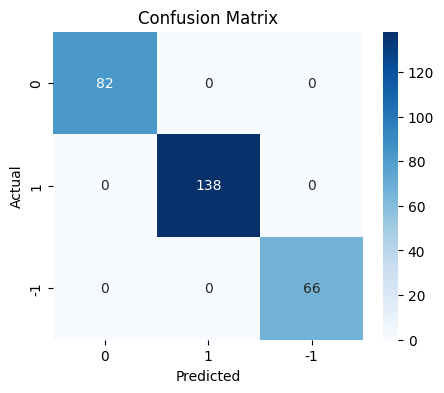

In [61]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

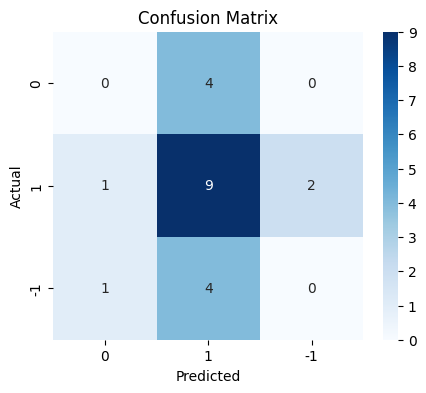

In [62]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [63]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [64]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision       F1
0  0.428571  0.428571   0.302521  0.35468


**Base Model - GloVe**

In [65]:
#Building the model

#Uncomment only one of the snippets related to fitting the model to the data

base_wv = GradientBoostingClassifier(random_state = 42)
#base_wv = RandomForestClassifier(random_state=42)
#base_wv = DecisionTreeClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_gl, y_train) #Complete the code to fit the chosen model on the train data

GradientBoostingClassifier(random_state=42)

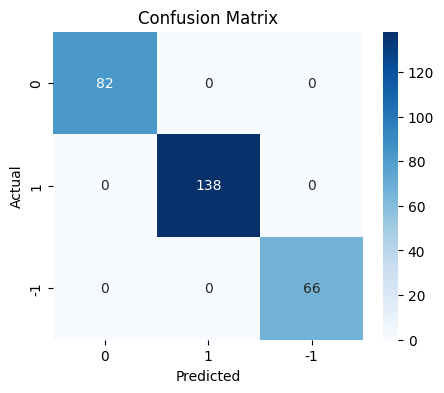

In [66]:
plot_confusion_matrix(base_wv,X_train_gl,y_train) #Complete the code to plot the confusion matrix for the train data

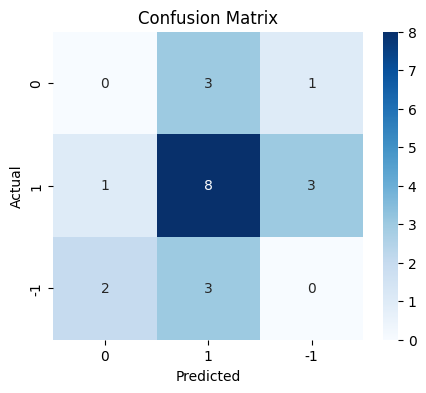

In [67]:
plot_confusion_matrix(base_wv,X_val_gl,y_val) #Complete the code to plot the confusion matrix for the validation data

In [68]:
#Calculating different metrics on training data
base_train_gl=model_performance_classification_sklearn(base_wv,X_train_gl,y_train) #Complete the code to compute the model performance for the training data
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [69]:
#Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_wv,X_val_gl,y_val) #Complete the code to compute the model performance for the validation data
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.326531  0.351648


**Base Model - Sentence Transformer**

In [70]:
# Building the model

#Uncomment only one of the snippets related to fitting the model to the data

base_wv = GradientBoostingClassifier(random_state = 42)
#base_wv = RandomForestClassifier(random_state=42)
#base_wv = DecisionTreeClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_st, y_train) #Complete the code to fit the chosen model on the train data

GradientBoostingClassifier(random_state=42)

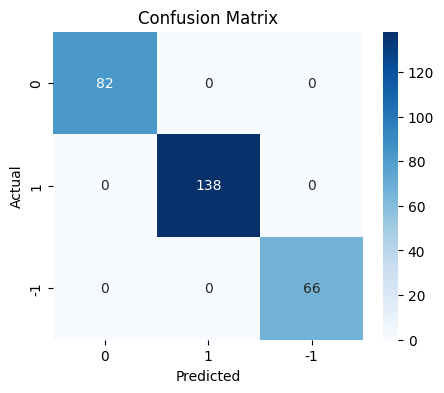

In [71]:
plot_confusion_matrix(base_wv,X_train_st, y_train) #Complete the code to plot the confusion matrix for the train data

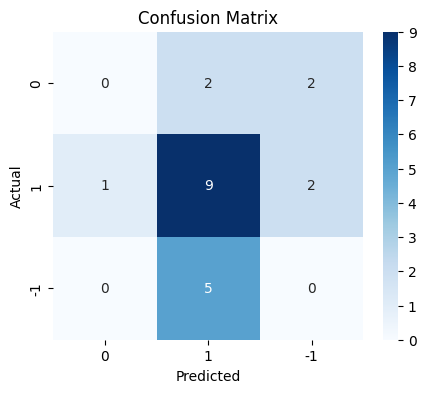

In [72]:
plot_confusion_matrix(base_wv,X_val_st, y_val) #Complete the code to plot the confusion matrix for the validation data

In [73]:
#Calculating different metrics on training data
base_train_st=model_performance_classification_sklearn(base_wv,X_train_st, y_train) #Complete the code to compute the model performance for the training data
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [74]:
#Calculating different metrics on validation data
base_val_st = model_performance_classification_sklearn(base_wv,X_val_st, y_val) #Complete the code to compute the model performance for the validation data
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.321429  0.367347


**Tuned Model - Word2Vec**

In [75]:
start = time.time()

# Choose the type of classifier.

#Uncomment only one of the snippets corrrsponding to the base model trained previously

tuned_wv = GradientBoostingClassifier(random_state = 42)
#tuned_wv = RandomForestClassifier(random_state=42)
#tuned_wv = DecisionTreeClassifier(random_state=42)


parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the Randomize search
#grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = RandomizedSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)

grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  41.68192219734192


In [76]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(max_features=0.2, min_samples_split=7,
                           random_state=42)

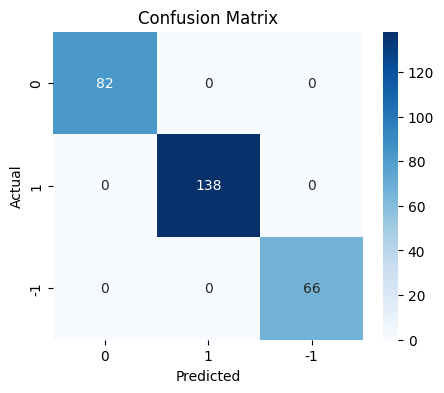

In [77]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

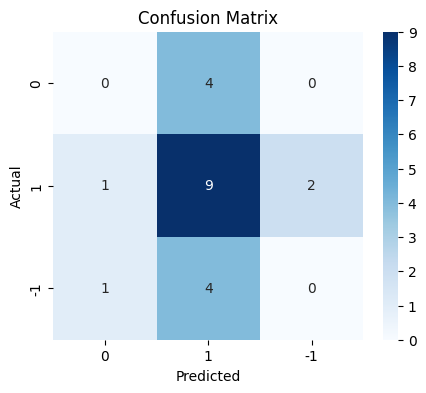

In [78]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [79]:
#Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [80]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision       F1
0  0.428571  0.428571   0.302521  0.35468


**Tuned Model - GloVe**

In [81]:
start = time.time()

#Uncomment only one of the snippets corrrsponding to the base model trained previously

tuned_wv = GradientBoostingClassifier(random_state = 42)
#tuned_wv = RandomForestClassifier(random_state=42)
#tuned_wv = DecisionTreeClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the Randomized search
#grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1) #Complete the code to pass the chosen model
grid_obj = RandomizedSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1) #Complete the code to pass the chosen model

grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  13.524409294128418


In [82]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_gl, y_train) #Complete the code to fit the chosen model on the train data

GradientBoostingClassifier(max_depth=5, max_features='log2',
                           min_samples_split=9, random_state=42)

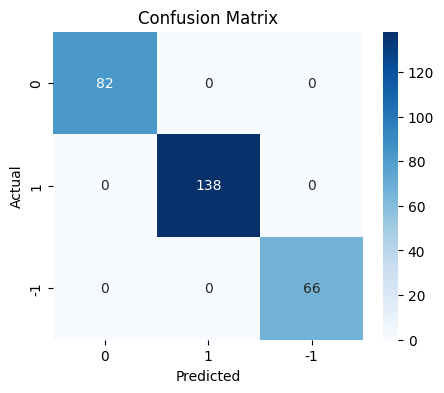

In [83]:
plot_confusion_matrix(tuned_gl,X_train_gl, y_train) #Complete the code to plot the confusion matrix for the train data

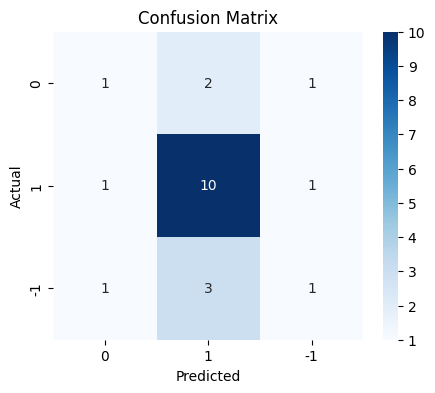

In [84]:
plot_confusion_matrix(tuned_gl,X_val_gl, y_val) #Complete the code to plot the confusion matrix for the validation data

In [85]:
#Calculating different metrics on training data
tuned_train_gl=model_performance_classification_sklearn(tuned_gl,X_train_gl, y_train) #Complete the code to compute the model performance for the training data
print("Training performance:\n",tuned_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [86]:
#Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl, y_val) #Complete the code to compute the model performance for the validation data
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429    0.52381  0.537226


**Tuned Model - Sentence Transformer**

In [87]:
start = time.time()

# Choose the type of classifier.

#Uncomment only one of the snippets corrrsponding to the base model trained previously

tuned_wv = GradientBoostingClassifier(random_state = 42)
#tuned_wv = RandomForestClassifier(random_state=42)
#tuned_wv = DecisionTreeClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the Randomized search
grid_obj = RandomizedSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1) #Complete the code to pass the chosen model
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  50.20201826095581


In [88]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_st, y_train) #Complete the code to fit the chosen model on the train data

GradientBoostingClassifier(max_depth=5, max_features=0.4, min_samples_split=7,
                           random_state=42)

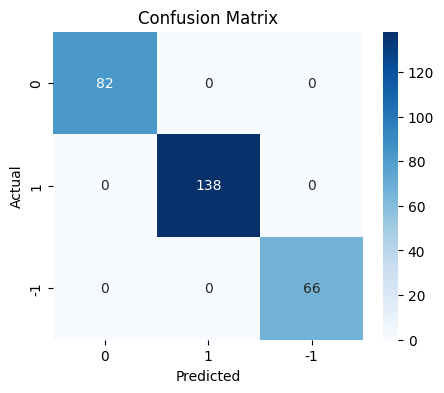

In [89]:
plot_confusion_matrix(tuned_st,X_train_st, y_train) #Complete the code to plot the confusion matrix for the train data

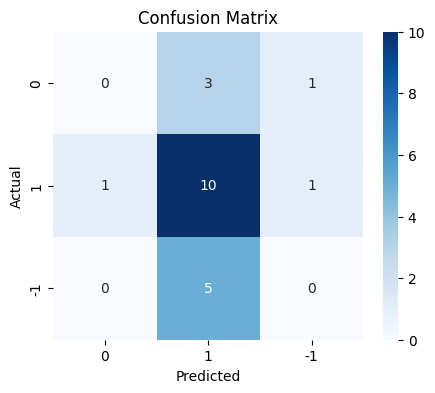

In [90]:
plot_confusion_matrix(tuned_st,X_val_st, y_val) #Complete the code to plot the confusion matrix for the validation data

In [91]:
#Calculating different metrics on training data
tuned_train_st=model_performance_classification_sklearn(tuned_st,X_train_st, y_train) #Complete the code to compute the model performance for the training data
print("Training performance:\n",tuned_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [92]:
#Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st, y_val) #Complete the code to compute the model performance for the validation data
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619    0.31746  0.380952


**Model Performance Summary and Final Model Selection**

In [93]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0,1.0,1.0
F1,1.0,1.0,1.0,1.0,1.0,1.0


In [94]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.428571,0.380952,0.428571,0.428571,0.571429,0.476190
Recall,0.428571,0.380952,0.428571,0.428571,0.571429,0.476190
Precision,0.302521,0.326531,0.321429,0.302521,0.523810,0.317460
F1,0.354680,0.351648,0.367347,0.354680,0.537226,0.380952


**Model Performance Check on Test Data**

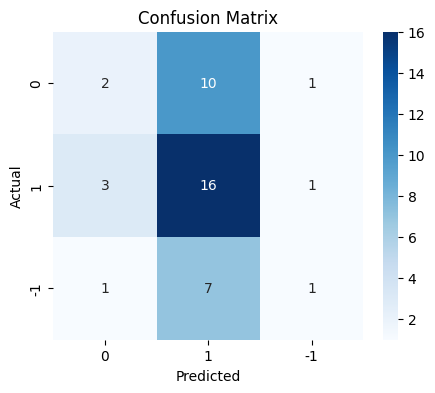

In [95]:
plot_confusion_matrix(tuned_st,X_test_st,y_test) #Complete the code to plot the confusion matrix for the final model and test data

In [96]:
#Calculating different metrics on training data
final_model_test = model_performance_classification_sklearn(tuned_st,X_test_st,y_test) #Complete the code to compute the final model's performance for the test data
print("Test performance for the final model:\n",final_model_test)

Test performance for the final model:
    Accuracy    Recall  Precision        F1
0  0.452381  0.452381   0.405483  0.388388


## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [124]:
import sys
!{sys.executable} -m pip install build-essential

'C:\Program' is not recognized as an internal or external command,
operable program or batch file.


In [122]:
!apt-get install build-essential

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [119]:
!pip install llama-cpp-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached llama_cpp_python-0.3.1.tar.gz (63.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
Using cached diskcache-5.6.3-py3-none-any.whl (45 kB)
Failed to build llama-cpp-python


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [20 lines of output]
  *** scikit-build-core 0.10.7 using CMake 3.31.0 (wheel)
  *** Configuring CMake...
  2024-11-13 20:21:53,801 - scikit_build_core - WARNING - Can't find a Python library, got libdir=None, ldlibrary=None, multiarch=None, masd=None
  loading initial cache file C:\Users\amitesh.sinha\AppData\Local\Temp\tmp47gtv2z1\build\CMakeInit.txt
  -- Building for: NMake Makefiles
  CMake Error at CMakeLists.txt:3 (project):
    Running
  
     'nmake' '-?'
  
    failed with:
  
     no such file or directory
  
  
  CMake Error: CMAKE_C_COMPILER not set, after EnableLanguage
  CMake Error: CMAKE_CXX_COMPILER not set, after EnableLanguage
  -- Configuring incomplete, errors occurred!
  
  *** CMake configuration failed
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for llama-cpp-python
ERROR: ERROR: Failed to build installable w

In [102]:
# For download the models
!pip3 install huggingface_hub

Defaulting to user installation because normal site-packages is not writeable


In [103]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python pip uninstall llama-cpp-python export  export  -vv python -c "from llama_cpp import GGML_USE_CUBLAS; print(GGML_USE_CUBLAS)"
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --no-cache-dir -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

In [112]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
#from langchain_community.llms import LlamaCpp
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

ModuleNotFoundError: No module named 'llama_cpp'

#### Loading the data

In [ ]:
stock_news = pd.read_csv("stock_news.csv")

In [ ]:
data = stock_news.copy()

#### Loading the model

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"


model_path = hf_hub_download(
    repo_id=model_name_or_path, # Complete the code to mention the repo_id
    filename=model_basename # Complete the code to mention the filename
)

In [ ]:
#uncomment the below snippet of code if the runtime is connected to GPU.
llm = Llama(
    model_path=model_path, # Path to the model
    n_gpu_layers=100, #Number of layers transferred to GPU
    n_ctx=4500, #Context window
)

#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

In [ ]:
weekly_grouped

In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=1024, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=0, #Complete the code to set the value for temperature.
      top_p=0.95, #Complete the code to set the value for top_p
      top_k=50, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [ ]:
news = data_1.loc[0, 'News']

In [ ]:
print(len(news.split(' ')))
news

In [ ]:
#Complete the code to define the prompt for this task
prompt = """
    You are an AI analyzing news articles. Tag the given article using one or more of the below mentioned categories only depending upon the content of the article:
    - World
    - Sports
    - Business
    - Sci/Tech
"""

In [ ]:
%%time
summary = response_mistral_1(prompt, news)
print(summary)

##### Checking the model output on the weekly data

In [ ]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

In [ ]:
data_1["Key Events"].head() #Complete the code to print the first 5 rows of the 'Key_Events' column

##### Formatting the model output

In [ ]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

In [ ]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

In [ ]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

## **Conclusions and Recommendations**

-




<font size=6 color='blue'>Power Ahead</font>
___